In [1]:
import functools
import jax
import os

from datetime import datetime
from jax import numpy as jp
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output

import brax

import flax
from brax.envs import env
from brax import envs
from brax import base
from brax.io import model
from brax.io import json
from brax.io import html
from brax.io import mjcf

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
#@title Load Env { run: "auto" }

env_name = 'ant'  # @param ['ant', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'inverted_pendulum', 'inverted_double_pendulum', 'pusher', 'reacher', 'walker2d']
backend = 'positional'  # @param ['generalized', 'positional', 'spring']

ant_env = envs.get_environment(env_name=env_name,
                              backend=backend)
state = jax.jit(ant_env.reset, backend="cpu")(rng=jax.random.PRNGKey(seed=0))

HTML(html.render(ant_env.sys, [state.pipeline_state]))

In [3]:
# an attempt to create the class A1 for the A1 robot XML

class A1(env.PipelineEnv):
    def __init__(
        self, 
        path="a1/xml/a1.xml", 
        backend='generalized',
        reset_noise_scale=0.1,
        **kwargs
    ):
        sys = mjcf.load(path)
        n_frames = 1
        kwargs['n_frames'] = kwargs.get('n_frames', n_frames)
        
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        self.qd_size = self.sys.qd_size()
        self.q_size = self.sys.q_size()
        self._reset_noise_scale = reset_noise_scale
        
    def reset(self, rng: jp.ndarray) -> env.State:
        rng, rng1, rng2 = jax.random.split(rng, 3)
        # q = self.sys.init_q
        
        # sit down
        q = jp.array([
            0., 0., 0.14, 
            1., 0., 0., 0., 
            0., 1.4, -2.6, 
            0., 1.4, -2.6, 
            0., 1.4, -2.6, 
            0., 1.4, -2.6
        ]) 
        
        # standing up
        # q = jp.array([
        #     0., 0., 0.4, 
        #     1.0, 0.0, 0., 0., 
        #     0.0, 0.7, -1.5, 
        #     0.0, 0.7, -1.5, 
        #     0.0, 0.7, -1.5, 
        #     0.0, 0.7, -1.5
        # ]) 
        
        qd = jp.zeros(self.qd_size) # velocity initialized to 0
        
        # low, hi = -self._reset_noise_scale, self._reset_noise_scale
        # q = self.sys.init_q + jax.random.uniform(
        #     rng1, (self.q_size,), minval=low, maxval=hi
        # )
        # qd = hi * jax.random.normal(rng2, (self.qd_size,))
        
        pipeline_state = self.pipeline_init(q, qd)
        obs = self._get_obs(pipeline_state)
        
        reward, done, zero = jp.zeros(3)
        info = {}
        
        return env.State(pipeline_state, obs, reward, done, info)

    def _get_obs(self, pipeline_state: base.State) -> jp.ndarray:
        """Observe ant body position and velocities."""	
        qpos = pipeline_state.q
        qvel = pipeline_state.qd

        return jp.concatenate([qpos] + [qvel])
    
    def step(self, state: env.State, action: jp.ndarray) -> env.State:
        """Run one timestep of the environment's dynamics."""
        pipeline_state0 = state.pipeline_state
        pipeline_state = self.pipeline_step(pipeline_state0, action)
        obs = self._get_obs(pipeline_state)
        
        reward, done, zero = jp.zeros(3)
        info = {}
        
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )

In [4]:
a1_env = A1()
state = jax.jit(a1_env.reset, backend="cpu")(rng=jax.random.PRNGKey(seed=0))
# HTML(html.render(a1_env.sys, [state.pipeline_state]))
with open("render.html", "w") as file:
    file.write(html.render(a1_env.sys.replace(dt=0.1), [state.pipeline_state]))
file.close()

/home/duynguyen/miniconda3/envs/spirit-rl-pybullet/lib/python3.8/site-packages/brax/io/mjcf.py:381: UserWarning: unrecognized collider, geom_type: 5
  warnings.warn(f'unrecognized collider, geom_type: {typ}')


In [5]:
jit_env_reset = jax.jit(a1_env.reset, backend="cpu")
jit_env_step = jax.jit(a1_env.step, backend="cpu")

In [6]:
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

current_joint = jp.array([
    0., 1.4, -2.6, 
    0., 1.4, -2.6, 
    0., 1.4, -2.6, 
    0., 1.4, -2.6
])

reference_joint = jp.array([
    0.0, 0.8, -1.6, 
    0.0, 0.8, -1.6, 
    0.0, 0.8, -1.6, 
    0.0, 0.8, -1.6
])

trajectory = jp.linspace(current_joint, reference_joint, 100)

for i in range(200):
    if i < 100:
        reference_pos = trajectory[i]
        
    rollout.append(state.pipeline_state)
    joint_pos = state.pipeline_state.q[7:]
    joint_vel = state.pipeline_state.qd[6:]
    e_pos = reference_pos - joint_pos
    e_v = jp.zeros(12) - joint_vel
    
    feedback_abduction = e_pos*120.0 + e_v*0.5
    abduction_action = jp.array([feedback_abduction[j] for j in [0, 3, 6, 9]])
    
    feedback_hip = e_pos*80.0 + e_v*1.0
    hip_action = jp.array([feedback_hip[j] for j in [1, 4, 7, 10]])
    
    feedback_knee = e_pos*120.0 + e_v*2.0
    knee_action = jp.array([feedback_knee[j] for j in [2, 5, 8, 11]])

    action = jp.array([abduction_action, hip_action, knee_action]).T.reshape(-1)
    state = jit_env_step(state, action)

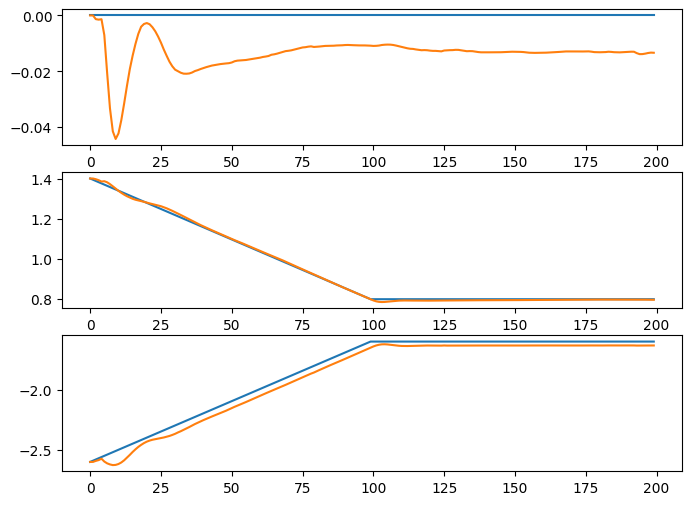

In [7]:
fig, ax = plt.subplots(3, 1)
fig.set_size_inches((8, 6))
for i in range(3):
    ax[i].plot(trajectory[:, i].tolist() + [trajectory[-1, i]] * 100)
    ax[i].plot([x.q[7 + i] for x in rollout])
plt.show()

In [159]:
with open("render.html", "w") as file:
    file.write(html.render(a1_env.sys, rollout))
file.close()

In [ ]:
state.pipeline_state.x.rot[0]

In [ ]:
state.pipeline_state.q[3:7]

Define the following state variables to be available:

| state variable      | state reference                                         |
----------------------|---------------------------------------------------------|
| z                   | `q[2]` or `x[2]`                                        |
| roll, pitch, yaw    | `brax.math.quat_to_euler(.)` with `q[3:7]` or `x.rot[0]`|
| w_x, w_y, w_z       | `xd.ang[0]` or `qd[3:6]`                                |
| v_x, v_y, v_z       | `xd.vel[0]` or `qd[:3]`                                 |
| theta_j (joint pos) | `q[7:]`                                                 |
| theta_j_dot         | `qd[6:]`                                                |

In [ ]:
# get jacobian matrix
def integrate_forward(x, u):
    pipeline_state = a1_env.pipeline_init(x[:19], x[19:])
    qpos = pipeline_state.q
    qvel = pipeline_state.qd
    obs = jp.concatenate([qpos] + [qvel])
    reward, done, zero = jp.zeros(3)
    info = {}
    state = jit_env_step(env.State(pipeline_state, obs, reward, done, info), u)
    
    q = state.pipeline_state.q
    qd = state.pipeline_state.qd
    return jp.concatenate((q, qd), axis=0)

jacobian_fn = jax.jit(jax.jacfwd(integrate_forward, argnums=[0, 1]))

q = state.pipeline_state.q
qd = state.pipeline_state.qd
action = jp.ones(12) # dummy control
x = jp.concatenate((q, qd), axis=0)

state = jit_env_step(state, action)
A, B = jacobian_fn(x, action)
print(A.shape, B.shape)

In [ ]:
# a better attempt to avoid re-initializing the pipeline
def integrate_forward(x, u, state):
    state = jit_env_step(state.replace(pipeline_state=state.pipeline_state.replace(q=x[:19], qd=x[19:])), u)
    q = state.pipeline_state.q
    qd = state.pipeline_state.qd
    return jp.concatenate((q, qd), axis=0)

jax_integrate_forward = jax.jit(jax.jacfwd(integrate_forward, argnums=[0, 1]), backend="cpu")

In [ ]:
q = state.pipeline_state.q
qd = state.pipeline_state.qd
action = jp.ones(12) # dummy control
x = jp.concatenate((q, qd), axis=0)

A, B = jax_integrate_forward(x, action, state)
print(A.shape, B.shape)

Add low-level control (positional control) to A1 class

In [4]:
class A1(env.PipelineEnv):
    def __init__(
        self, 
        path="a1/xml/a1.xml", 
        backend='generalized',
        reset_noise_scale=0.1,
        **kwargs
    ):
        sys = mjcf.load(path)
        n_frames = 1
        kwargs['n_frames'] = kwargs.get('n_frames', n_frames)
        
        super().__init__(sys=sys, backend=backend, **kwargs)
        
        self.qd_size = self.sys.qd_size()
        self.q_size = self.sys.q_size()
        self._reset_noise_scale = reset_noise_scale
        
    def reset(self, rng: jp.ndarray) -> env.State:
        # sit down
        q = jp.array([
            0., 0., 0.14, 
            1., 0., 0., 0., 
            0., 1.4, -2.6, 
            0., 1.4, -2.6, 
            0., 1.4, -2.6, 
            0., 1.4, -2.6
        ]) 
        
        qd = jp.zeros(self.qd_size) # velocity initialized to 0
        
        pipeline_state = self.pipeline_init(q, qd)
        obs = self._get_obs(pipeline_state)
        
        reward, done, zero = jp.zeros(3)
        info = {}
        
        return env.State(pipeline_state, obs, reward, done, info)

    def _get_obs(self, pipeline_state: base.State) -> jp.ndarray:
        """Observe ant body position and velocities."""	
        qpos = pipeline_state.q
        qvel = pipeline_state.qd

        return jp.concatenate([qpos] + [qvel])
    
    def step(self, state: env.State, action: jp.ndarray) -> env.State:
        """Run one timestep of the environment's dynamics."""
        # low level control turning reference position (input action) to torque:
        pipeline_state0 = state.pipeline_state
        
        joint_pos = pipeline_state0.q[7:]
        joint_vel = pipeline_state0.qd[6:]
        e_pos = action - joint_pos
        e_v = jp.zeros(12) - joint_vel

        feedback_abduction = e_pos*120.0 + e_v*0.5
        abduction_action = jp.array([feedback_abduction[j] for j in [0, 3, 6, 9]])

        feedback_hip = e_pos*80.0 + e_v*1.0
        hip_action = jp.array([feedback_hip[j] for j in [1, 4, 7, 10]])

        feedback_knee = e_pos*120.0 + e_v*2.0
        knee_action = jp.array([feedback_knee[j] for j in [2, 5, 8, 11]])

        action = jp.array([abduction_action, hip_action, knee_action]).T.reshape(-1)
        
        pipeline_state = self.pipeline_step(pipeline_state0, action)
        obs = self._get_obs(pipeline_state)
        
        reward, done, zero = jp.zeros(3)
        info = {}
        
        return state.replace(
            pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
        )

In [5]:
a1_env = A1()
jit_env_reset = jax.jit(a1_env.reset, backend="cpu")
jit_env_step = jax.jit(a1_env.step, backend="cpu")

/home/duynguyen/miniconda3/envs/spirit-rl-pybullet/lib/python3.8/site-packages/brax/io/mjcf.py:381: UserWarning: unrecognized collider, geom_type: 5
  warnings.warn(f'unrecognized collider, geom_type: {typ}')


In [8]:
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

current_joint = jp.array([
    0., 1.4, -2.6, 
    0., 1.4, -2.6, 
    0., 1.4, -2.6, 
    0., 1.4, -2.6
])

reference_joint = jp.array([
    0.0, 0.8, -1.6, 
    0.0, 0.8, -1.6, 
    0.0, 0.8, -1.6,
    0.0, 0.8, -1.6
])

trajectory = jp.linspace(current_joint, reference_joint, 100)

for action in trajectory:
    rollout.append(state.pipeline_state)
    state = jit_env_step(state, action)

for _ in range(100):
    rollout.append(state.pipeline_state)
    state = jit_env_step(state, trajectory[-1])

with open("render.html", "w") as file:
    file.write(html.render(a1_env.sys, rollout))
file.close()

In [9]:
# jacobian, but the action space now is angular position instead of torque
def integrate_forward(x, u, state):
    new_state = jit_env_step(
        state.replace(pipeline_state=state.pipeline_state.replace(q=x[:19], qd=x[19:])), u
    )
    return jp.append(new_state.pipeline_state.q, new_state.pipeline_state.qd)

jax_integrate_forward = jax.jit(jax.jacfwd(integrate_forward, argnums=[0, 1]), backend="cpu")

In [11]:
import time

q = state.pipeline_state.q
qd = state.pipeline_state.qd
action = reference_joint + jp.ones(12)*0.1
x = jp.concatenate((q, qd), axis=0)

cur_time = time.time()
A, B = jax_integrate_forward(x, action, state)
print(time.time() - cur_time)

print(A.shape, B.shape)

2.385932207107544
(37, 37) (37, 12)


Inverse kinematics performance controller test

In [5]:
from inverse_kinematics.inverse_kinematics_controller import InverseKinematicsController

In [6]:
# controller = InverseKinematicsController(Xdist=0.366, Ydist=0.17, height=0.25, coxa=0.038, femur=0.2, tibia=0.2, L=0.8, angle=0, T=1.0, dt=0.01)
controller = InverseKinematicsController(Xdist=0.366, Ydist=0.28, height=0.25, coxa=0.038, femur=0.2, tibia=0.2, L=0.8, angle=0, T=1.0, dt=0.01)

In [7]:
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

current_joint = jp.array([
    0., 1.4, -2.6, 
    0., 1.4, -2.6, 
    0., 1.4, -2.6, 
    0., 1.4, -2.6
])

# stand up
reference_joint = jp.array([
    0.0, 0.6, -1.5, 
    0.0, 0.6, -1.5, 
    0.0, 0.6, -1.5,
    0.0, 0.6, -1.5
])

trajectory = jp.linspace(current_joint, reference_joint, 100)

for action in trajectory:
    rollout.append(state.pipeline_state)
    state = jit_env_step(state, action)

# move from stable stance to first step of performance controller
reference_joint = jp.array(controller.get_action(
    joint_order = ["FR", "FL", "BR", "BL"], offset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
))

trajectory = jp.linspace(state.pipeline_state.q[7:], reference_joint, 50)

for action in trajectory:
    rollout.append(state.pipeline_state)
    state = jit_env_step(state, action)

# start walking
for _ in range(500):
    rollout.append(state.pipeline_state)
    action = jp.array(controller.get_action(
        joint_order = ["FR", "FL", "BR", "BL"], offset=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ))
    state = jit_env_step(state, action)

with open("render.html", "w") as file:
    file.write(html.render(a1_env.sys, rollout, height=800))
file.close()